In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 1. Setup

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import math
import seaborn as sbs


In [3]:
data_valid = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

data = data_valid.copy()

data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 2. Data analysis

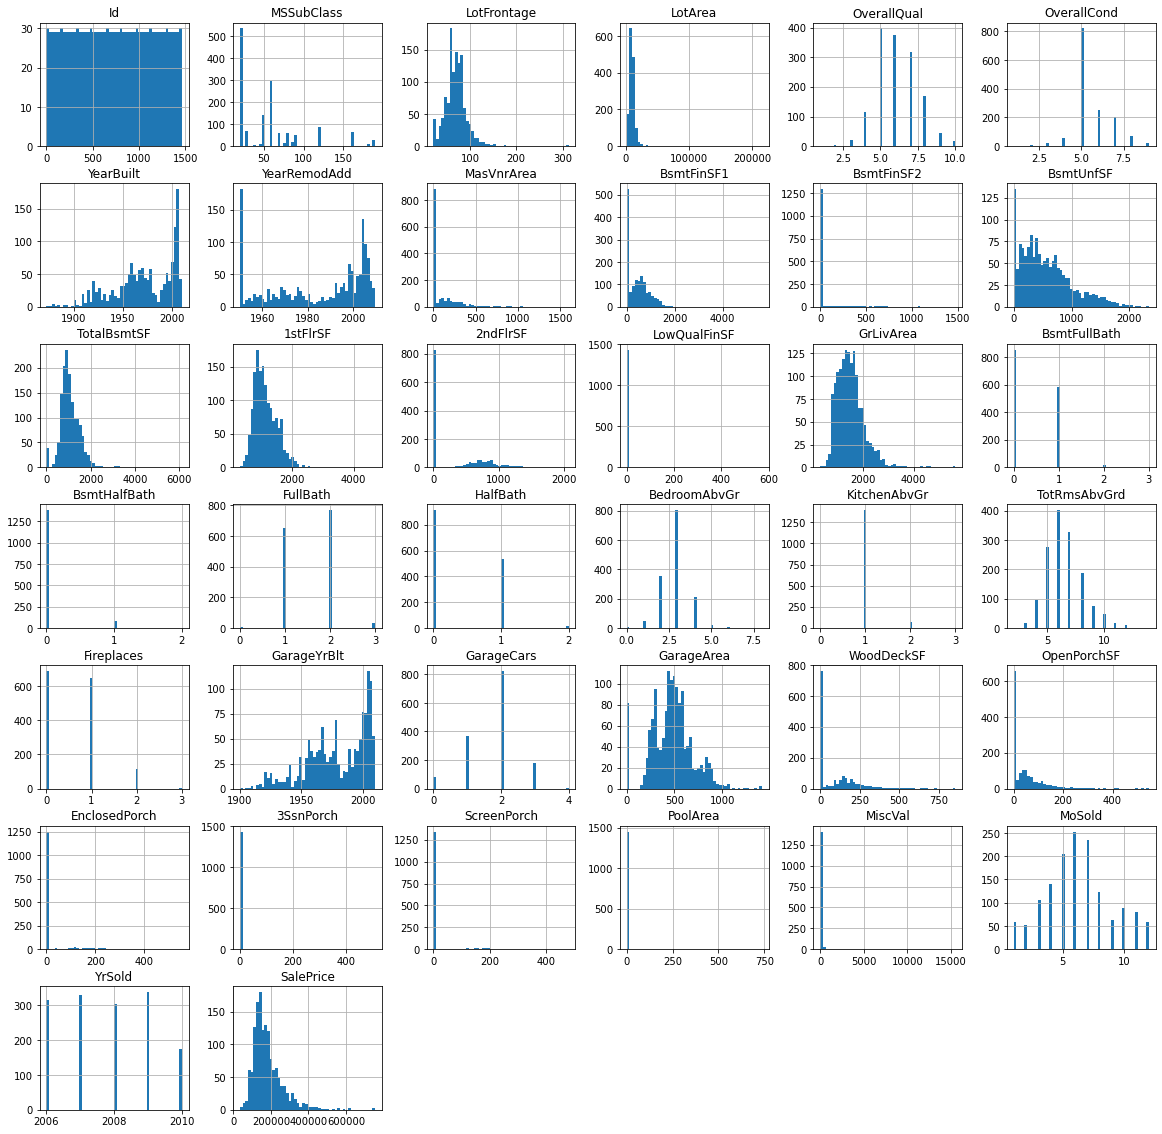

In [5]:
data.hist(bins=50, figsize=(20,20))
plt.show()

<AxesSubplot:>

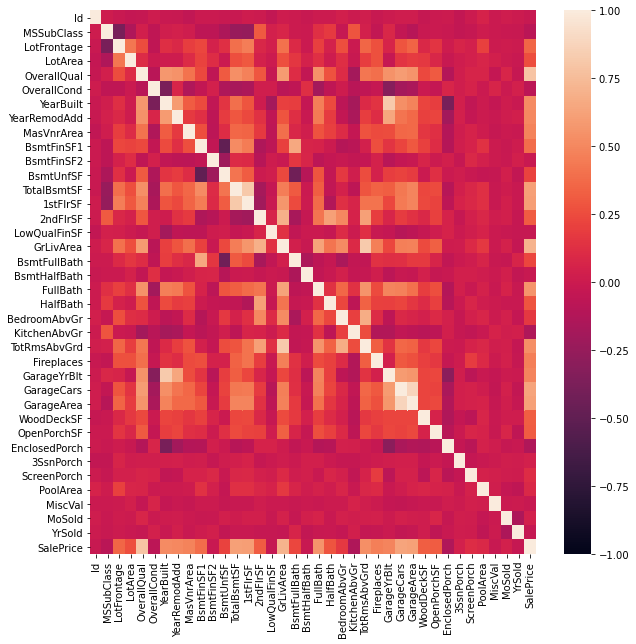

In [6]:
# Correlation with target 'SalePrice'
corr = data.corr(method='pearson')
plt.figure(figsize=(10, 10))
sbs.heatmap(corr, vmin=-1, vmax=1)

Let's find top 10 most correlated numeric features with 'SalesPirce'

In [7]:
most_corr_columns = corr['SalePrice'].sort_values(ascending=False)[1:11]
most_corr_columns

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

# 3. Data preprocessing

In [8]:
# find single instances in columns

def find_cat_columns(df):
    # return array with columns names if their type is 'object'
    column_names = np.array(df.columns)
    is_cat = np.array(df[column_names].dtypes == 'O')
    return np.array(column_names[is_cat])


def drop_single_cat_instances(df):
    # function looking for single category instances in categorical columns, and delete rows that consists them.
    
    cat_columns = find_cat_columns(df)
    
    # check whether any value appears once in given column,
    # if so drop row that consist this value
    for column in cat_columns:
        value_cnt = dict(data[column].value_counts())
        for key in value_cnt:
            if value_cnt[key] < 3:
                # print(key, 'in column:', column) <- for debug only
        
                # retrieve index value of a row and drop it
                idx_to_drop = df[df[column] == key].index
                df.drop(idx_to_drop, inplace=True)
                

In [9]:
def preproccess_input(df):
    # remove columns with highest NaN values
    ID = df['Id']
    col_to_drop = ['LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'Id']
    for col in col_to_drop:
        df.drop(col, axis=1, inplace=True)
    
    # fill missing values with the highest distribiution value in each column
    columns_to_fill = np.array(df.columns[df.isna().sum() > 0])
    value_to_fill = pd.Series(df[columns_to_fill].value_counts().index[0])
    
    for index, col in enumerate(columns_to_fill):
        df[col].fillna(value=value_to_fill[index], inplace=True)
            
    output = df
    return output

In [10]:
# custom transformers

from sklearn.base import BaseEstimator, TransformerMixin


class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('Custom Encoder initialized')
        from sklearn.preprocessing import OneHotEncoder
        self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        self.categorical_data = None
        self.cat_columns = None
        
    def fit(self, X, y=None):
        self.cat_columns = find_cat_columns(X)
        self.categorical_data = X[self.cat_columns]
        self.encoder.fit(self.categorical_data)
        return self
    
    def transform(self, X, y=None):
        # return encode_input(X, self.encoder)
        # find categorical features
        
        categorical_data_encoded = self.encoder.transform(self.categorical_data)
        ohe_columns = self.encoder.get_feature_names(self.cat_columns)
    
        # create dateframe
        encoded_dataframe = pd.DataFrame(categorical_data_encoded, columns=ohe_columns)
    
        # concatenate
        encoded_df = pd.concat([X.reset_index(drop=True), encoded_dataframe.reset_index(drop=True)], axis=1, ignore_index=False)
    
        # delete original cat columns
        encoded_df.drop(self.cat_columns, axis=1, inplace=True)
    
        return encoded_df

    
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('Custom Scaler initialized')
        from sklearn.preprocessing import StandardScaler
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X, y=None):
        column_names = X.columns
        scaled_data = self.scaler.transform(X)
        scaled_df = pd.DataFrame(scaled_data, columns=column_names)
        return scaled_df
    

# 4. Training

In [11]:
final_preprocessor = Pipeline(steps=[
    ('Encoding', CustomEncoder()),
    ('scaler', CustomScaler()),
])


Custom Encoder initialized
Custom Scaler initialized


In [12]:
X = preproccess_input(data)

# remove instances that occurs less than 3 times before train-test splitting
drop_single_cat_instances(X)

# extract target column
y_target = X['SalePrice']
X = X.drop('SalePrice', axis=1)

# do encoding and scaling
X_processed = final_preprocessor.fit_transform(X)



# split data 
x_train, x_test, y_train, y_test = train_test_split(X_processed, y_target, test_size=0.2, random_state=42)

In [13]:
x_train.shape

(1132, 236)

* **testing few models to find out how good they can estimate with default hyperparameters**

In [14]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [15]:
forest_reg = RandomForestRegressor()
sgd_reg = SGDRegressor()
gb_reg = GradientBoostingRegressor()
svr_reg = SVR()
tree_reg = DecisionTreeRegressor()
lgbm_reg = LGBMRegressor()
xgb_reg = XGBRegressor()

reg_list = [forest_reg, sgd_reg, gb_reg, svr_reg, tree_reg, lgbm_reg, xgb_reg]

for reg in reg_list:
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    mse = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mse)
    print('Model:', reg, 'RMSE:', rmse, '\n')


Model: RandomForestRegressor() RMSE: 24221.46468305123 

Model: SGDRegressor() RMSE: 25721.55350044021 

Model: GradientBoostingRegressor() RMSE: 20935.38283835906 

Model: SVR() RMSE: 80070.73125093602 

Model: DecisionTreeRegressor() RMSE: 39708.93559433866 

Model: LGBMRegressor() RMSE: 22886.44186090635 

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) RMSE: 23794.55442005626 



## Plot feature importances top 4 models

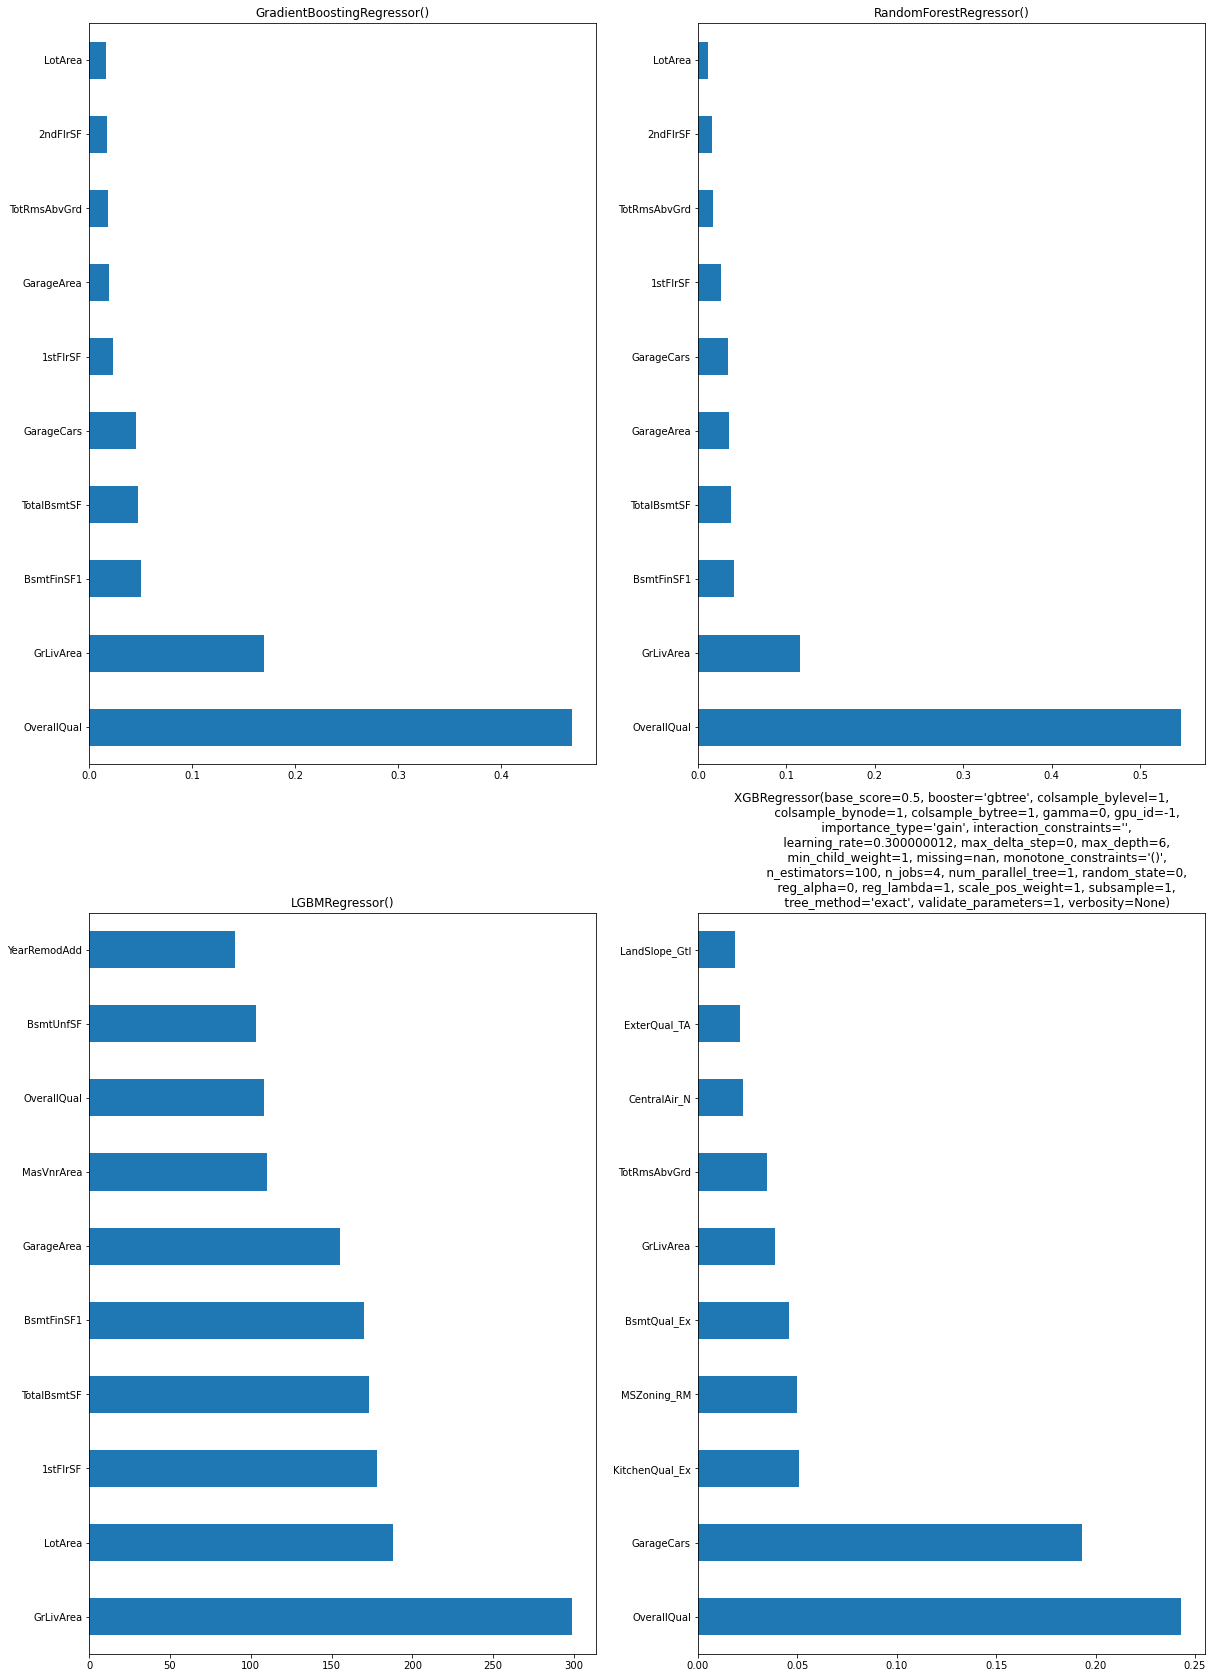

In [16]:
plt.figure(figsize=(20, 30))

top_models = [gb_reg, forest_reg, lgbm_reg, xgb_reg]

for i in range(1, 5):
    plt.subplot(2,2,i)
    plt.title(str(top_models[i-1]))
    (pd.Series(top_models[i-1].feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh'))

# 5.Fine tuning 

The most optimistic regressor is the one that is based on GradientBoosting. In this case it will be GradientBoostinRegressor model

In order to fine tune it we must tweak 3 hyperparameters:

1. Max_depth
2. N_estimators
3. Learning Rate


In [17]:
gbrt_tuning = GradientBoostingRegressor(random_state=42)

In [18]:
# estimate the best n_estimators value

estimator_values = []
min_val_error = float("inf")
error_going_up = 0
for n_estimator in range(1,200):
    gbrt_tuning.n_estimators = n_estimator
    gbrt_tuning.fit(x_train, y_train)
    pred = gbrt_tuning.predict(x_test)
    val_error = mean_squared_error(y_test, pred)
    rmse = np.sqrt(val_error)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 8:
            print('The best n_estimator value: ', n_estimator)
            print('RMSE:', rmse, '\n')
            estimator_values.append(n_estimator)
            break # early stopping
    

The best n_estimator value:  162
RMSE: 20417.682836195883 



MIN RMSE: 20417.682836195883


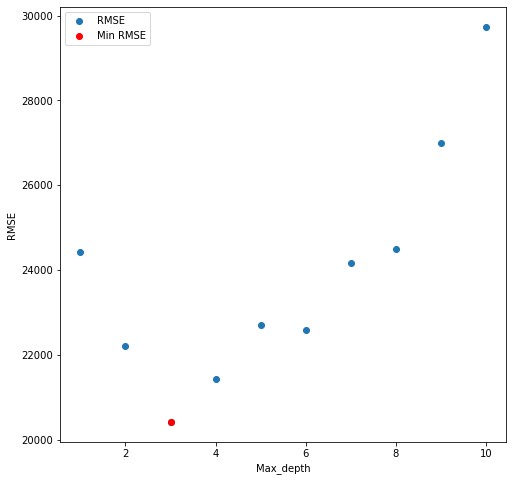

In [19]:
# estimate max depth and plot graph

min_error = float("inf")
rmse_list = []
for depth in range(1,11):
    gbrt_tuning.max_depth = depth
    gbrt_tuning.fit(x_train, y_train)
    y_pred = gbrt_tuning.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse_per_depth = np.sqrt(mse)
    
    # collect every rmse and then plot graph
    rmse_list.append(rmse_per_depth)
    
    if mse < min_error:
        min_error = mse
        max_depth_best = depth

print('MIN RMSE:', np.sqrt(min_error))

gbrt_tuning.max_depth = max_depth_best

plt.figure(figsize=(8, 8))
plt.scatter(range(1, 11), rmse_list, label='RMSE')
plt.scatter(max_depth_best, rmse_list[max_depth_best-1], c='red', label='Min RMSE')
plt.xlabel('Max_depth')
plt.ylabel('RMSE')
plt.legend()

In [20]:
# tune learning rate

min_error = float("inf")
best_rate = 0

for rate in [0.01, 0.03, 0.05, 0.08, 0.09, 0.1]:
    gbrt_tuning.learning_rate = rate
    gbrt_tuning.fit(x_train, y_train)
    y_pred = gbrt_tuning.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    rmse = np.sqrt(mse)
    
    print('RMSE:', rmse)
    if mse < min_error:
        min_error = mse
        min_rmse = np.sqrt(min_error)
        best_rate = rate


gbrt_tuning.learning_rate = rate    
print('MIN RMSE:', min_rmse, 'Learning rate:', best_rate, '\n')

RMSE: 34084.446631463434
RMSE: 22515.00425842082
RMSE: 21267.171855821216
RMSE: 20383.479298864662
RMSE: 20358.469505930756
RMSE: 20417.682836195883
MIN RMSE: 20358.469505930756 Learning rate: 0.09 



# Results

In [21]:
pred = gbrt_tuning.predict(x_test)
mse = mean_squared_error(pred, y_test)

rmse= np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 20417.682836195883


# 6. Submission

In [22]:
test_validation = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test_validation

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [23]:
ID = test_validation['Id']

In [24]:
# preprocess data
test_preprocessed = preproccess_input(test_validation)
test_preprocessed

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,32,0,0,0,0,700,7,2006,WD,Normal


In [25]:
# encoding and scaling

test_ready = final_preprocessor.transform(test_preprocessed)
test_ready

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.872626,0.118800,-0.811994,0.388276,-0.357861,-1.174794,-0.576138,0.064504,0.630721,-0.680661,...,-0.059549,-0.301628,-0.046094,0.385408,-0.266755,-0.053243,-0.092483,-0.119737,0.464366,-0.305792
1,-0.872626,0.384763,-0.076887,0.388276,-0.457869,-1.320869,0.026971,1.119112,-0.282305,-0.373525,...,-0.059549,-0.301628,-0.046094,0.385408,-0.266755,-0.053243,-0.092483,-0.119737,0.464366,-0.305792
2,0.078291,0.340821,-0.811994,-0.527408,0.842234,0.626798,-0.576138,0.813160,-0.282305,-0.981021,...,-0.059549,-0.301628,-0.046094,0.385408,-0.266755,-0.053243,-0.092483,-0.119737,0.464366,-0.305792
3,0.078291,-0.046510,-0.076887,0.388276,0.875569,0.626798,-0.464452,0.375092,-0.282305,-0.558710,...,-0.059549,-0.301628,-0.046094,0.385408,3.748759,-0.053243,-0.092483,-0.119737,-2.153474,-0.305792
4,1.504666,-0.546562,1.393326,-0.527408,0.675554,0.334648,-0.576138,-0.410649,-0.282305,1.006328,...,-0.059549,-0.301628,-0.046094,0.385408,-0.266755,-0.053243,-0.092483,-0.119737,0.464366,-0.305792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.455583,-0.855160,-1.547100,1.303960,-0.057837,-0.736569,-0.576138,-1.020235,-0.282305,-0.057356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1455,2.455583,-0.859383,-1.547100,-0.527408,-0.057837,-0.736569,-0.576138,-0.436145,-0.282305,-0.626460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,-0.872626,0.961236,-0.811994,1.303960,-0.391197,0.529414,-0.576138,1.816775,-0.282305,-1.290416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1457,0.672614,0.000046,-0.811994,-0.527408,0.675554,0.334648,-0.576138,-0.239130,-0.282305,0.008136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
test_ready = test_ready.fillna(-1)

In [27]:
# prediction
predictions = gbrt_tuning.predict(test_ready)
predictions


array([136766.07777998, 174305.55088362, 189912.28515748, ...,
       165110.32464106, 123885.40036549, 241821.71309199])

In [28]:
submission = pd.DataFrame({'Id': ID, 'SalePrice': predictions})

In [29]:
submission.to_csv('submission.csv', index=False)